# Baselines (Secondary Structure Predictor)

In [ ]:
# import the libraries
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
from dask_ml.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

/root/venv/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 9.0.0. Please consider upgrading.
  warnings.warn(


In [ ]:
# import and see train_data_p_unp.csv
df_train_p_unp_csv = dd.read_csv("Data/train_data_p_unp.csv").iloc[:, 1:]
df_train_p_unp_csv.head()

,sequence_id,sequence,experiment_type,dataset_name,reads,signal_to_noise,SN_filter,reactivity_0001,reactivity_0002,reactivity_0003,...,p_unp_197,p_unp_198,p_unp_199,p_unp_200,p_unp_201,p_unp_202,p_unp_203,p_unp_204,p_unp_205,p_unp_206
0,bad76a72215c,GGGAACGACUCGAGUAGAGUCGAAAAUAAAUUCAGCGGUAAUUCCU...,2A3_MaP,PK50_AltChemMap_NovaSeq_2A3,10863,4.653,1,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,f037cc8df765,GGGAACGACUCGAGUAGAGUCGAAAAUACCGAGAAAGAUCCUCGGU...,2A3_MaP,PK50_AltChemMap_NovaSeq_2A3,51489,13.139,1,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,e63fe5ebb069,GGGAACGACUCGAGUAGAGUCGAAAACGGGCAAACUAGAAAAGCCC...,2A3_MaP,PK50_AltChemMap_NovaSeq_2A3,15508,11.417,1,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,a4a9f51c982e,GGGAACGACUCGAGUAGAGUCGAAAAGGGUCCAGCCUGGAAAGGCU...,2A3_MaP,PK50_AltChemMap_NovaSeq_2A3,360466,38.127,1,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,e671ff55d619,GGGAACGACUCGAGUAGAGUCGAAAAGAAAAAGGCAAGGACCAGCC...,2A3_MaP,PK50_AltChemMap_NovaSeq_2A3,15609,5.699,1,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
# apply SN-filter
df_sn = df_train_p_unp_csv[df_train_p_unp_csv["SN_filter"]==1]

# split into 2A3 MaP and DMS MaP datasets
df_2A3 = df_sn[df_sn["experiment_type"]=="2A3_MaP"]
df_DMS = df_sn[df_sn["experiment_type"]=="DMS_MaP"]

# split into train, validate, test
X_2A3 = df_2A3.loc[:, ["sequence"] + [f"p_unp_{i}" for i in range(1,206+1)]]
y_2A3 = df_2A3.loc[:, df_2A3.columns.str.fullmatch("reactivity_\d\d\d\d")]
X_2A3_train_valid, X_2A3_test, y_2A3_train_valid, y_2A3_test = train_test_split(X_2A3, y_2A3, test_size=0.2, shuffle=True, blockwise=True, random_state=42)
X_2A3_train, X_2A3_valid, y_2A3_train, y_2A3_valid = train_test_split(X_2A3_train_valid, y_2A3_train_valid, test_size=0.25, shuffle=True, blockwise=True, random_state=42)

X_DMS = df_DMS.loc[:, ["sequence"] + [f"p_unp_{i}" for i in range(1,206+1)]]
y_DMS = df_DMS.loc[:, df_DMS.columns.str.fullmatch("reactivity_\d\d\d\d")]
X_DMS_train_valid, X_DMS_test, y_DMS_train_valid, y_DMS_test = train_test_split(X_DMS, y_DMS, test_size=0.2, shuffle=True, blockwise=True, random_state=42)
X_DMS_train, X_DMS_valid, y_DMS_train, y_DMS_valid = train_test_split(X_DMS_train_valid, y_DMS_train_valid, test_size=0.25, shuffle=True, blockwise=True, random_state=42)

In [ ]:
# import and see test_seq_p_unp.csv
df_test_p_unp_csv = dd.read_csv("Data/test_seq_p_unp.csv").iloc[:, 1:]
df_test_p_unp_csv.head()

,id_min,id_max,sequence_id,sequence,future,p_unp_1,p_unp_2,p_unp_3,p_unp_4,p_unp_5,...,p_unp_448,p_unp_449,p_unp_450,p_unp_451,p_unp_452,p_unp_453,p_unp_454,p_unp_455,p_unp_456,p_unp_457
0,66779028,66779234,b294a66d5f12,GGGAACGACUCGAGUAGAGUCGAAAAACUGGAACGGCGUCAUCGCC...,1,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,66779235,66779441,0c460f720dae,GGGAACGACUCGAGUAGAGUCGAAAACGAAAGCAUCUCGCCACGGC...,1,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,66795795,66796001,2a1b99b3aa40,GGGAACGACUCGAGUAGAGUCGAAAAGGCGUGGCGAGACUACCCUG...,1,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,66832641,66832847,d7182e4d86e9,GGGAACGACUCGAGUAGAGUCGAAAACGCCGUGGGCCACGUUGAGA...,1,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,66841335,66841541,e03be4f520dd,GGGAACGACUCGAGUAGAGUCGAAAAAACUUAAAAUUGCACAAAAU...,1,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
# create mutate and map dataset
id1=269545321
id2=269724007
df_mmap = df_test_p_unp_csv[(id1 <= df_test_p_unp_csv["id_min"]) & (df_test_p_unp_csv["id_max"] <= id2)].loc[:, ["sequence"] + [f"p_unp_{i}" for i in range(1,457+1)]]

## Secondary Structure Predictor Baseline

- Use P(unpaired) values from LinearPartition EternaFold Package

In [ ]:
# 2A3 MAE
p_unp_val = X_2A3_test.loc[:, [f"p_unp_{i}" for i in range(1, 206+1)]]
p_unp_val.columns = y_2A3_test.columns
mean_absolute_error(y_2A3_test.clip(0, 1), p_unp_val)

0.4282209444939349

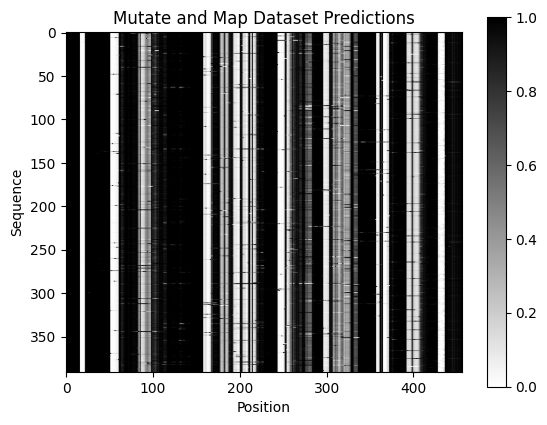

In [ ]:
# 2A3 MMAP
df_mmap_pred = df_mmap.loc[:, [f"p_unp_{i}" for i in range(1, 457+1)]]
plt.imshow(df_mmap_pred.compute(), vmin=0,vmax=1, cmap='gray_r')
plt.colorbar()
plt.title("Mutate and Map Dataset Predictions")
plt.xlabel("Position")
plt.ylabel("Sequence")
plt.show()

In [ ]:
# DMS MAE
p_unp_val = X_DMS_test.loc[:, [f"p_unp_{i}" for i in range(1, 206+1)]]
p_unp_val.columns = y_DMS_test.columns
mean_absolute_error(y_DMS_test.clip(0, 1), p_unp_val)

0.43795726864616163

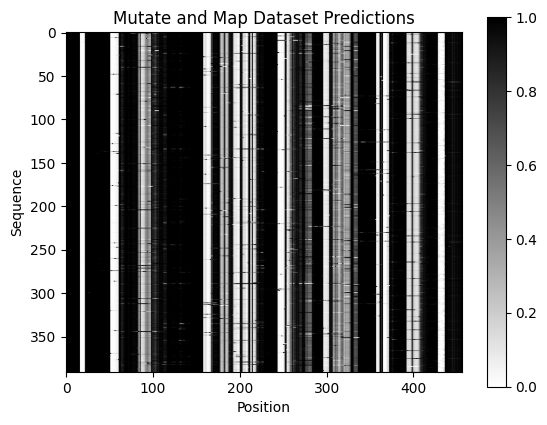

In [ ]:
# DMS MMAP
df_mmap_pred = df_mmap.loc[:, [f"p_unp_{i}" for i in range(1, 457+1)]]
plt.imshow(df_mmap_pred.compute(), vmin=0,vmax=1, cmap='gray_r')
plt.colorbar()
plt.title("Mutate and Map Dataset Predictions")
plt.xlabel("Position")
plt.ylabel("Sequence")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fe343e39-d2c0-4296-915d-091d9a42752d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>